# Calculations related to f_diffuse (aka $f_d$) [v1]
    These were presented in XYZ+2019 and Macquart+2020 (more or less)
    But see Simha+2020 for the latest

In [1]:
#%matplotlib notebook

In [2]:
# imports
from importlib import reload
import numpy as np
import os

from pkg_resources import resource_filename

from matplotlib import pyplot as plt

from scipy import interpolate

from astropy import units
from astropy.table import Table
from astropy.cosmology import Planck15

from frb.dm import igm

## Stellar mass (baryons locked up)

In [3]:
#stellar_mass_file = resource_filename('frb', 'data/IGM/stellarmass.dat')
stellar_mass_file = resource_filename('frb', os.path.join('data','IGM','stellarmass.dat'))

In [4]:
rho_mstar_tbl = Table.read(stellar_mass_file, format='ascii')

In [5]:
rho_mstar_tbl[0:5]

z,t_Gyr,rho_Mstar
float64,float64,float64
0.0,13.48,576600000.0
0.1,12.18,560400000.0
0.2,11.05,542400000.0
0.3,10.06,522900000.0
0.4,9.194,501900000.0


### Method

In [6]:
zval = np.linspace(0., 4., 100)
rho_Mstar = igm.avg_rhoMstar(zval, remnants=False)

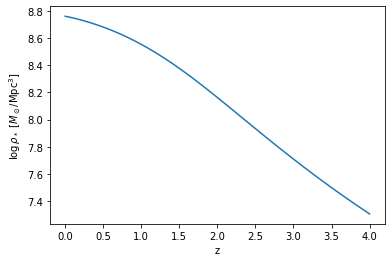

In [7]:
plt.clf()
ax = plt.gca()
ax.plot(zval, np.log10(rho_Mstar.value))
# Label
ax.set_xlabel('z')
ax.set_ylabel(r'$\log \, \rho_* \; [M_\odot/ \rm Mpc^3]$ ')
plt.show()

### Following Fukugita 2004 (Table 1)

In [8]:
M_sphere = 0.0015
M_disk = 0.00055
M_WD = 0.00036
M_NS = 0.00005
M_BH = 0.00007
M_BD = 0.00014

In [9]:
f_remnants = (M_WD+M_NS+M_BH+M_BD) / (M_sphere+M_disk)
f_remnants

0.30243902439024395

In [10]:
rho_Mstar_full = igm.avg_rhoMstar(zval, remnants=True)

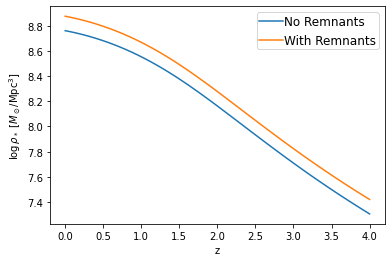

In [11]:
plt.clf()
ax = plt.gca()
ax.plot(zval, np.log10(rho_Mstar.value), label='No Remnants')
ax.plot(zval, np.log10(rho_Mstar_full.value), label='With Remnants')
# Label
ax.set_xlabel('z')
ax.set_ylabel(r'$\log \, \rho_* \; [M_\odot/ \rm Mpc^3]$ ')
# Legend
legend = plt.legend(loc='upper right', scatterpoints=1, borderpad=0.2,
                       handletextpad=0.1, fontsize='large')
plt.show()

## ISM

### $z=0$  -- Fukugita 2004

In [12]:
M_HI = 0.00062
M_H2 = 0.00016
M_ISM = M_HI + M_H2

In [13]:
M_ISM/(M_sphere+M_disk)

0.38048780487804873

In [14]:
# In code
f04_dict = igm.fukugita04_dict()
M_ISM = f04_dict['M_HI'] + f04_dict['M_H2']
f_ISM_0 = M_ISM/(f04_dict['M_sphere']+f04_dict['M_disk'])
f_ISM_0

0.38048780487804873

### $z>0$ -- Could use DLAs and [silly] K-S relation?

### Instead, assume $M_{\rm ISM} = M_*$ at $z=1$ and smoothly interpolate with time

In [15]:
t0 = Planck15.age(0.).to('Gyr').value
t1 = Planck15.age(1.).to('Gyr').value
#
t0, t1

(13.79761589678864, 5.862549254978376)

In [16]:
f_ISM = interpolate.interp1d([t0, t1], [f_ISM_0, 1.], bounds_error=False, fill_value=1.)

In [17]:
tval = Planck15.age(zval).to('Gyr').value

In [18]:
f_ISM(tval)

array([0.3804878 , 0.42470646, 0.46641858, 0.50579492, 0.54299175,
       0.57815262, 0.61140989, 0.64288592, 0.67269408, 0.70093961,
       0.72772036, 0.75312736, 0.77724542, 0.80015356, 0.82192551,
       0.84263001, 0.86233121, 0.88108902, 0.89895935, 0.9159944 ,
       0.93224295, 0.94775056, 0.9625598 , 0.97671048, 0.99023978,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

### Do it

In [19]:
reload(igm)
rhoISM = igm.avg_rhoISM(zval)

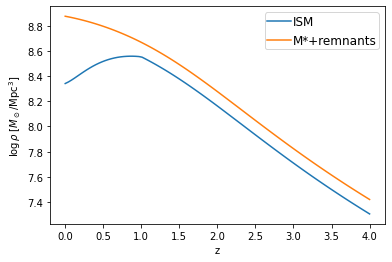

In [20]:
plt.clf()
ax = plt.gca()
ax.plot(zval, np.log10(rhoISM.value), label='ISM')
ax.plot(zval, np.log10(rho_Mstar_full.value), label='M*+remnants')
# Label
ax.set_xlabel('z')
ax.set_ylabel(r'$\log \, \rho \; [M_\odot/ \rm Mpc^3]$ ')
# Legend
legend = plt.legend(loc='upper right', scatterpoints=1, borderpad=0.2,
                       handletextpad=0.1, fontsize='large')
plt.show()

## $Y$ -- Helium
    https://arxiv.org/abs/1807.09774

In [21]:
#He_file = resource_filename('frb', 'data/IGM/qheIII.txt')
He_file = resource_filename('frb', os.path.join('data','IGM','qheIII.txt'))

In [22]:
qHeIII = Table.read(He_file, format='ascii')

In [23]:
qHeIII

z,Q_HeIII_18,Q_HeIII_18_l,Q_HeIII_18_u,Q_HeIII_21,Q_HeIII_21_l,Q_HeIII_21_u
float64,float64,float64,float64,float64,float64,float64
12.0,1e-10,1e-10,1e-10,1e-10,1e-10,1e-10
11.988,4.374927e-09,2.218632e-10,1.508848e-07,1.860788e-09,2.667322e-10,1.104288e-08
11.976,8.743113e-09,3.519406e-10,3.034705e-07,3.67851e-09,4.431452e-10,2.215664e-08
11.964,1.320629e-08,4.904414e-10,4.578895e-07,5.554472e-09,6.294819e-10,3.344437e-08
11.952,1.776445e-08,6.373657e-10,6.141419e-07,7.488672e-09,8.257424e-10,4.490605e-08
11.94,2.24176e-08,7.927134e-10,7.722276e-07,9.48111e-09,1.031927e-09,5.654171e-08
11.928,2.716575e-08,9.564846e-10,9.321466e-07,1.153179e-08,1.248034e-09,6.835133e-08
11.916,3.200887e-08,1.128679e-09,1.093899e-06,1.36407e-08,1.474066e-09,8.033491e-08
11.904,3.694699e-08,1.309297e-09,1.257485e-06,1.580786e-08,1.710021e-09,9.249246e-08


### Plot

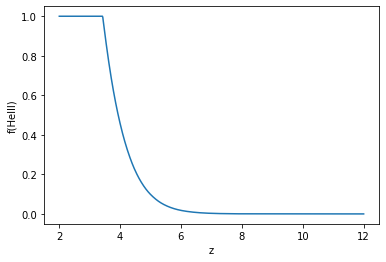

In [24]:
plt.clf()
ax=plt.gca()
ax.plot(qHeIII['z'], qHeIII['Q_HeIII_18'])
#
ax.set_xlabel('z')
ax.set_ylabel('f(HeIII)')
#
plt.show()

# $f_{\rm diffuse}$

In [25]:
reload(igm)
f_diffuse = igm.f_diffuse(zval)

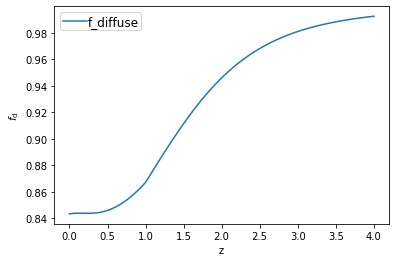

In [26]:
plt.clf()
ax = plt.gca()
ax.plot(zval, f_diffuse, label='f_diffuse')
# Label
ax.set_xlabel('z')
ax.set_ylabel(r'$f_{\rm d}$')
# Legend
legend = plt.legend(loc='upper left', scatterpoints=1, borderpad=0.2,
                       handletextpad=0.1, fontsize='large')
plt.show()

----